In [471]:
from scripts.SimulatedUser import SimulatedUser
from utils.ElasticSearch import create_elasticsearch_client, create_index, index_news_articles
from utils.sqlitedb import save_user_profile, create_db, delete_db

First, delete any current user profile database and create a new one.

In [472]:
delete_db()
create_db()

Database deleted successfully.
Database and table created successfully.


In [473]:
DATA_FILE = "data/News_Category_Dataset_v3.json"
client = create_elasticsearch_client()
index_name = "news_articles"
create_index(client, index_name)

Index 'news_articles' already exists and will be used.


/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## Targeted User Generation

In [474]:
num_queries_per_user = 0

# Define targeted user preferences
targeted_users = [
  (SimulatedUser(user_id="sportive"), ["SPORTS", "HEALTHY LIVING", "ENTERTAINMENT", "TRAVEL"]),
  (SimulatedUser(user_id="activist"), ["POLITICS", "BLACK VOICES", "QUEER VOICES"]),
  (SimulatedUser(user_id="businessman"), ["BUSINESS"])
]

# Simulate search behavior for targeted users and print profiles
for user, preferences in targeted_users:
  user.simulate_search_targeted(client, index_name, num_queries_per_user, preferences)
  # user.print_profile()
  save_user_profile(user.profile)

### DCG

In [475]:
from math import log2
def dcg(rel):
  dcg = 0
  for i in range(len(rel)):
    dcg += rel[i] / log2(i + 2)
  return dcg

def ndcg(rel):
  rel_sorted = sorted(rel, reverse=True)
  ideal_dcg = dcg(rel_sorted)
  if ideal_dcg == 0:
    return 0
  return dcg(rel) / ideal_dcg

def precision(rel, k):
  # we'll have that every non-0 relevance is a relevant document; having as numbers can be 0, 1, 2 or 3
  return sum([1 for r in rel[:k] if r > 0]) / k

In [476]:
# Non-personalized search

from utils.search import build_query

def relevance_search(query, query_type, user=None):
  query = build_query(query_type, query)
  if user:
    query = user.profile.personalize_search(query)

  # Perform the search
  response = client.search(index=index_name, body=query, size=20)
  # Get the entries from the response
  entries = response['hits']['hits']
  print(f"{'Not-personalized' if user is None else 'User: ' + user.user_id}, Number of hits: {len(entries)}")

  # Print the entries
  for entry in entries:
    print("---")
    print(f"Title: {entry['_source']['headline']}")
    print(f"Category: {entry['_source']['category']}")
    print(f"Content: {entry['_source']['short_description']}")
  print("---------------------------------------------------")
  return entries

In [477]:
users = [user for user, _ in targeted_users]


In [478]:
# Searching "productive" with intersection
query = "productive"
query_type = "intersection"
productive_user_entries = []
for user in users:
  productive_user_entries.append(relevance_search(query, query_type, user))

User: sportive, Number of hits: 20
---
Title: Paul Ryan Says Call With Donald Trump Was Good, Productive
Category: POLITICS
Content: "We had a very good and very productive phone call," Ryan told reporters.
---
Title: How Good Habits Can Make You A Highly Productive Parent
Category: PARENTING
Content: Often I come across highly productive people in their business environment whose home life can only be described as horrendous
---
Title: Morning Routines for Productive People
Category: WELLNESS
Content: Productive people know that mornings are a great time for getting things done. And science shows that willpower is greatest in the morning. So take advantage of it and do the things that require self-discipline, like going to the gym or doing your taxes, early in the day.
---
Title: Top 5 Tips for Helping Lead a Productive and Happy Team
Category: BUSINESS
Content: I am managing a team of 11. My main goal is for them to be happy and productive. How do I optimize that experience for them?

/tmp/ipykernel_31753/1098158159.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = client.search(index=index_name, body=query, size=20)
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python

In [479]:
# Searching "parade" with intersection just for the activist user
query = "parade" # GOAL: political parades, rallies and similar
query_type = "intersection"
activist_user_entries = relevance_search(query, query_type, targeted_users[1][0])

# Searching "electric" with intersection just for the businessman user
query = "electric" # GOAL: electric vehicles and similar
query_type = "intersection"
businessman_user_entries = relevance_search(query, query_type, targeted_users[2][0])

# Searching "Chelsea" with intersection just for the sportive user
query = "Chelsea" # GOAL: Chelsea, football, Premier League and similar
query_type = "intersection"
sportive_user_entries = relevance_search(query, query_type, targeted_users[0][0])

/tmp/ipykernel_31753/1098158159.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = client.search(index=index_name, body=query, size=20)
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


User: activist, Number of hits: 20
---
Title: Golden State Warriors Join Riley Curry's Parade
Category: SPORTS
Content: The government wants you to think the parade was for the Warriors. It is a Riley Curry parade.
---
Title: Boston St. Patrick's Day Parade Reverses Ban On LGBTQ Group
Category: QUEER VOICES
Content: Parade organizers buckled after a fierce backlash.
---
Title: Highlights From The Macy's Thanksgiving Day Parade (PHOTOS)
Category: ENTERTAINMENT
Content: The annual New York City parade celebrated its 89th year.
---
Title: Trump's Military Parade Planned For Veterans Day — Without Tanks
Category: POLITICS
Content: The parade will cost taxpayers up to $30 million.
---
Title: Macy's Thanksgiving Day Parade Trivia
Category: PARENTING
Content: When you tune into the Macy's Thanksgiving Day parade this year with your kids, share these fun facts about the legendary event.
---
Title: Let LGBT Groups March in Little Saigon 'Tet' Parade!
Category: QUEER VOICES
Content: Whether the 

/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [483]:
# Assigning relevance scores for each user persona, for each query
# We'll also try with differing amounts of previous user queries - 0, 5, 10, 20, 100, 500
# (This has to be done manually)
relevance_scores = {
  "activist": {
    "productive - intersection": {
      "0": [1, 0, 1, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 3, 0, 0, 1, 0, 1, 2],
      "5": [1, 1, 1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0],
      "20": [1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 1],
      "100": [1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1],
      "500": [2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0, 2, 1, 3, 0, 1]
    },
    "parade - intersection": {
      "0": [0, 3, 1, 2, 1, 3, 1, 0, 0, 3, 3, 2, 0, 1, 0, 2, 1, 1, 1, 2],
      "5": [2, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1],
      "20": [2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 0],
      "100": [2, 2, 1, 2, 2, 3, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2],
      "500": [2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1, 2, 2, 2]
    }
  },
  "businessman": {
    "productive - intersection": {
      "0": [1, 1, 1, 3, 3, 2, 2, 2, 0, 1, 3, 3, 0, 0, 0, 2, 0, 1, 1, 2],
      "5": [3, 1, 3, 0, 2, 3, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 1],
      "20": [3, 2, 1, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2],
      "100": [2, 3, 1, 3, 2, 1, 2, 0, 2, 3, 3, 2, 2, 0, 1, 1, 2, 1, 2, 2],
      "500": [3, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 2, 0, 2, 2, 2, 2, 3, 3],
    },
    "electric - intersection": {
      "0": [0, 0, 2, 0, 0, 3, 0, 2, 2, 3, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0],
      "5": [1, 3, 2, 2, 0, 2, 3, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0],
      "20": [3, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 3, 0, 0, 0, 2, 0, 1, 0, 3],
      "100": [1, 3, 2, 1, 0, 2, 0, 0, 1, 3, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1],
      "500": [1, 3, 2, 1, 0, 2, 0, 0, 1, 2, 0, 3, 0, 0, 0, 2, 0, 0, 1, 1]
    }
  },
  "sportive": {
    "productive - intersection": {
      "0": [0, 1, 2, 1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
      "5": [0, 0, 2, 2, 2, 1, 1, 1, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 0],
      "20": [2, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2],
      "100": [0, 1, 1, 1, 3, 0, 0, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2],
      "500": [1, 1, 1, 1, 3, 0, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 1]
    },
    "Chelsea - intersection": {
      "0": [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 0, 3, 0, 0, 0, 0, 0],
      "5": [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 0],
      "20": [0, 1, 0, 3, 3, 3, 2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      "100": [1, 0, 3, 3, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      "500": [3, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 0, 0, 0]
    }
  }
}

In [489]:
# Now, for each user, for each query, for each amount of previous queries, we calculate the DCG, @5, @10 and @20
# Afterward, we plot it, with one line for each user persona, with the amount of previous queries on the x-axis and the DCG on the y-axis
# As such, considering that we have 3 DCG values, we'll have 3 plots!

import matplotlib.pyplot as plt

def calculate_metrics(relevance_scores):
  metrics = {}
  for user, user_data in relevance_scores.items():
    metrics[user] = {}
    for query, query_data in user_data.items():
      metrics[user][query] = {}
      for num_queries, scores in query_data.items():
        metrics[user][query][num_queries] = {
          "nDCG": {
            "@5": ndcg(scores[:5]),
            "@10": ndcg(scores[:10]),
            "@20": ndcg(scores[:20])
          },
          "Precision": {
            "@5": precision(scores, 5),
            "@10": precision(scores, 10),
            "@20": precision(scores, 20)
          }
        }
  return metrics

metrics = calculate_metrics(relevance_scores)

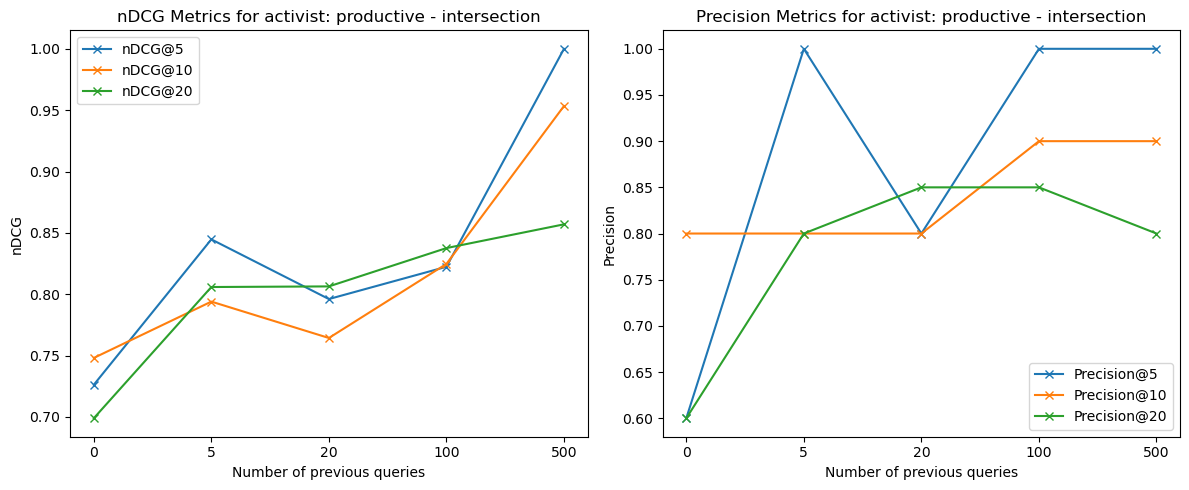

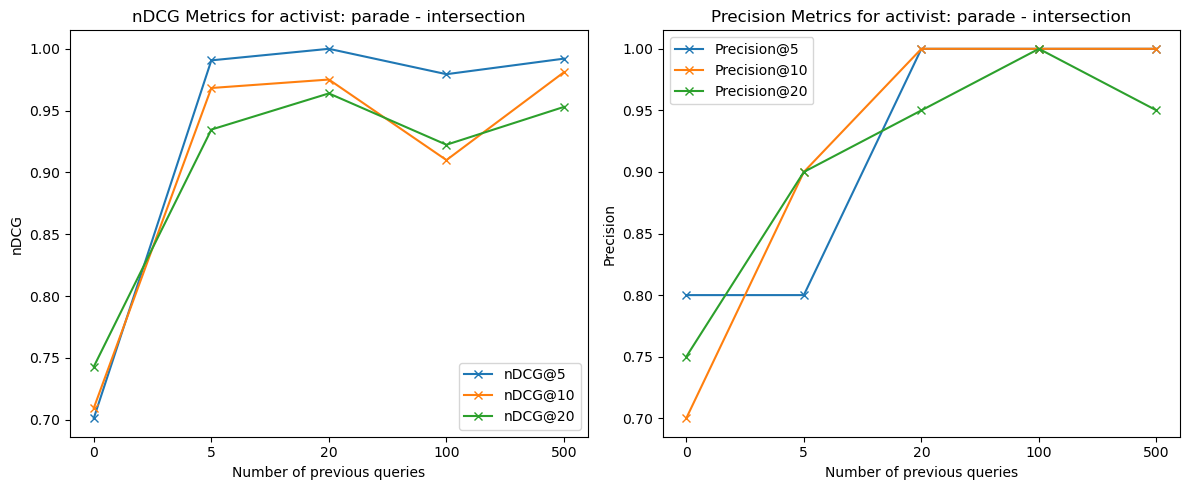

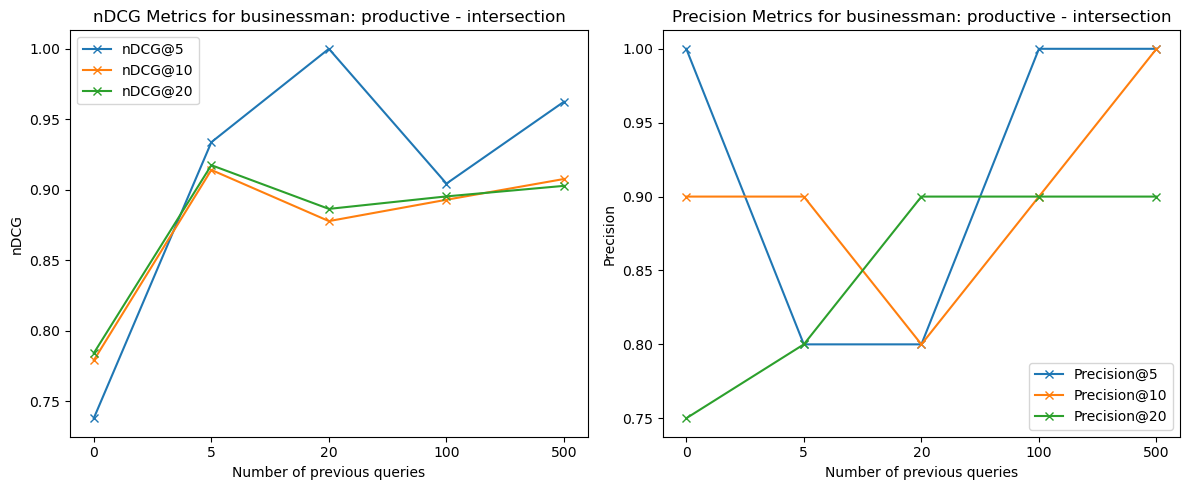

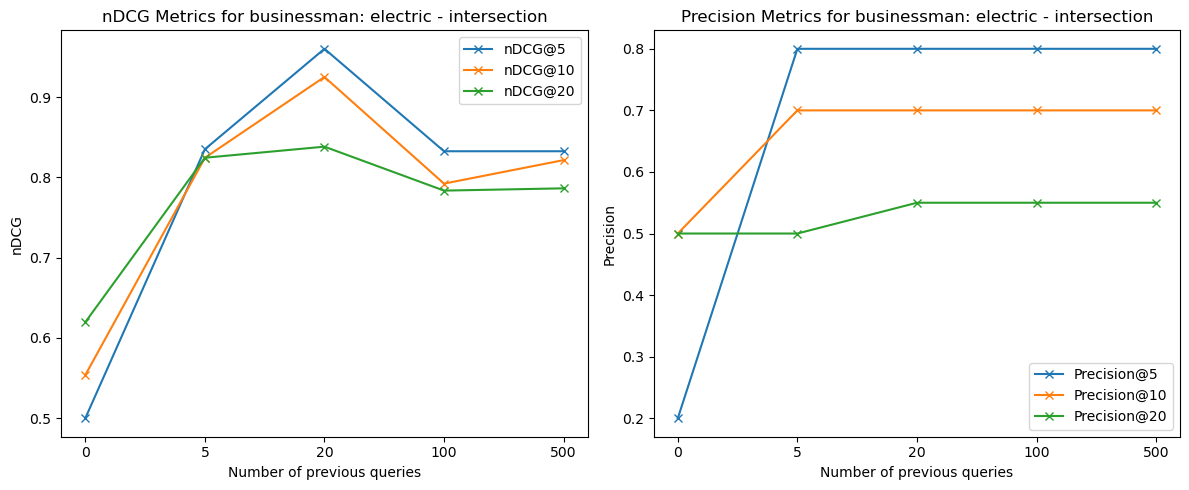

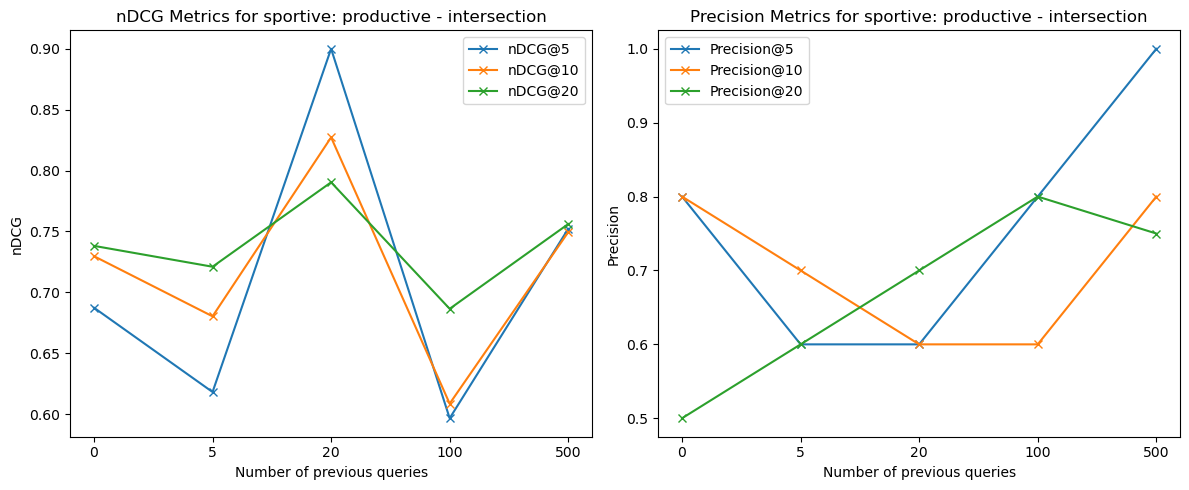

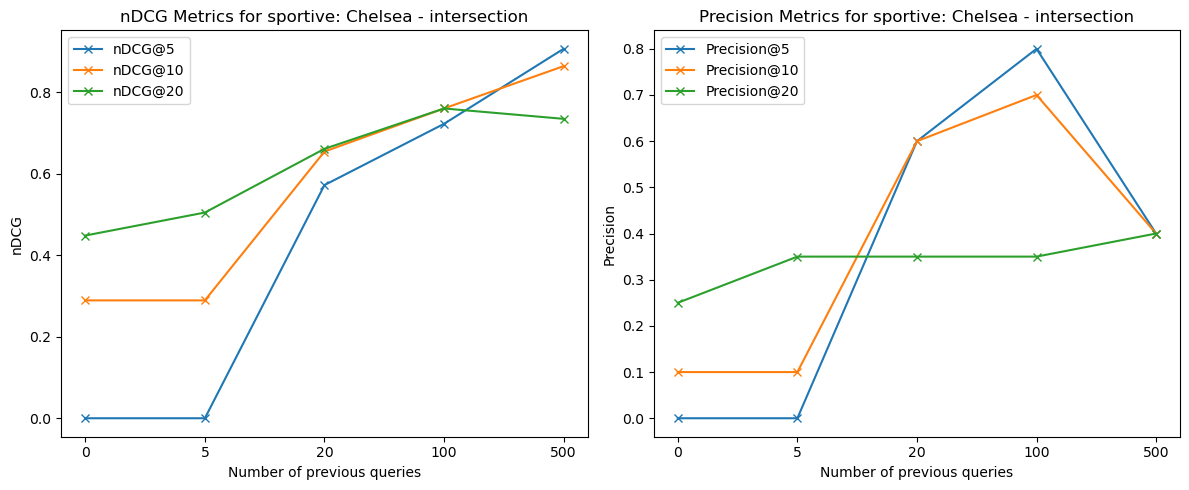

In [490]:
def plot_metrics(metrics):
    for user, user_data in metrics.items():
        for query, query_data in user_data.items():
            x = list(query_data.keys())
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Plot nDCG metrics
            ax1.plot(x, [query_data[num_queries]["nDCG"]["@5"] for num_queries in x], marker='x', label="nDCG@5")
            ax1.plot(x, [query_data[num_queries]["nDCG"]["@10"] for num_queries in x], marker='x', label="nDCG@10")
            ax1.plot(x, [query_data[num_queries]["nDCG"]["@20"] for num_queries in x], marker='x', label="nDCG@20")
            ax1.set_xlabel("Number of previous queries")
            ax1.set_ylabel("nDCG")
            ax1.set_title(f"nDCG Metrics for {user}: {query}")
            ax1.legend()

            # Plot Precision metrics
            ax2.plot(x, [query_data[num_queries]["Precision"]["@5"] for num_queries in x], marker='x', label="Precision@5")
            ax2.plot(x, [query_data[num_queries]["Precision"]["@10"] for num_queries in x], marker='x', label="Precision@10")
            ax2.plot(x, [query_data[num_queries]["Precision"]["@20"] for num_queries in x], marker='x', label="Precision@20")
            ax2.set_xlabel("Number of previous queries")
            ax2.set_ylabel("Precision")
            ax2.set_title(f"Precision Metrics for {user}: {query}")
            ax2.legend()

            plt.tight_layout()
            plt.show()

plot_metrics(metrics)

### Word Clouds

In [491]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [492]:
# First, acquiring the user profile term vector from each of the simulated users
term_preferences = [user.profile.term_preferences for user, categories in targeted_users]

In [493]:
# For each of the user profile term vectors, we will plot a word cloud
for i, user in enumerate(targeted_users):
  wc = WordCloud(width=800, height=800, background_color='white', max_words=150, colormap='viridis').generate_from_frequencies(term_preferences[i])
  plt.figure(figsize=(8, 5), facecolor=None)
  plt.imshow(wc)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.title(f"{user[0].user_id} - Term Preferences")
  plt.show()
  # save each word cloud to a file - in assets/wordcloud-{user_id}.png
  wc.to_file(f'assets/wordcloud-{user[0].user_id}.png')

ValueError: We need at least 1 word to plot a word cloud, got 0.